In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

In [2]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [3]:
## Pipline --- 数据预处理
## 对不同类型的数据做了基本的转化、将一些日期转换成间隔时间、删除缺失值过多的列

In [4]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [5]:
## Aggregator 类旨在生成用于聚合数据的表达式列表。

## 数值型：最大值、最小值、mean
## 日期型：最大值、最小值、mean
## str型：最大值、最后值
## 其他（T、L）：最大值、最后值
## 计数型：选择包含 "num_group" 的列，最大值、最后值

## 最后把这些表合成一个表

In [6]:
class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [7]:
## 读取数据并进行预处理
## 读取file，对深度 > 0的，Aggregator.get_exprs(df)
## 多files聚合后df.unique(subset=["case_id"]) 去除重复ID

In [8]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [9]:
## 特征工程


In [10]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [11]:
## 将 DataFrame 转换为 Pandas DataFrame，并可选地将指定列转换为分类类型

In [12]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [13]:
## 减少 DataFrame 的内存使用

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [15]:
ROOT            = Path("./")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [16]:
## 通过调用 read_file 和 read_files 函数来读取不同文件的数据，并将其存储在 data_store 字典中的相应键下
## 这些键是 "df_base"、"depth_0"、"depth_1" 和 "depth_2"

In [17]:
%%time
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

CPU times: user 2min 15s, sys: 1min 13s, total: 3min 29s
Wall time: 58.3 s


In [19]:
## 对训练数据进行进一步的特征处理和列选择
## 特征工程
## 释放内存
## Pipeline操作
## 转成Numpy，标注categorical
## 根据每个列的缺失值数量将列分组，并尝试通过相关性分析来减少每个组中的列数量。最后，选择的列保存在 uses 变量中

## 最终获得了df_train

In [20]:
%%time
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

train data shape:	 (1526659, 861)
Memory usage of dataframe is 4322.75 MB
Memory usage after optimization is: 1528.81 MB
Decreased by 64.6%
train data shape:	 (1526659, 472)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D

Use these ['mean_totalamount_996A']
####### NAN count = 636448
Use these ['mean_totaldebtoverduevalue_718A', 'mean_totaloutstanddebtvalue_668A', 'max_numberofcontrsvalue_358L']
####### NAN count = 297072
Use these ['max_dateofrealrepmt_138D', 'mean_dateofrealrepmt_138D']
####### NAN count = 512961
Use these ['max_lastupdate_388D', 'mean_lastupdate_388D']
####### NAN count = 512591
Use these ['max_numberofoverdueinstlmaxdat_148D']
####### NAN count = 802351
Use these ['mean_numberofoverdueinstlmaxdat_641D']
####### NAN count = 1012361
Use these ['mean_overdueamountmax2date_1002D']
####### NAN count = 806653
Use these ['max_overdueamountmax2date_1142D']
####### NAN count = 1007594
####### NAN count = 553734
####### NAN count = 822517
####### NAN count = 745109
####### NAN count = 545898
####### NAN count = 636545
####### NAN count = 545895
####### NAN count = 636544
####### NAN count = 512657
####### NAN count = 561307
####### NAN count = 649082
Use these ['last_num_group1_6']
####### NA

CPU times: user 1min 59s, sys: 3min 2s, total: 5min 2s
Wall time: 5min 52s


In [21]:
df_train.head()

## df_train.head(10000).to_excel('Kaggle源码_FinalTrainData.xlsx')

,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,last_conts_type_509L,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,0,0,0,1,4,30000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,19999.800781,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,78000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,PRIMARY_MOBILE,EMPLOYMENT_PHONE,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,40000.000000,0.0,1.0,0.0,2.0,...,NaN,NaN,PRIMARY_MOBILE,PRIMARY_EMAIL,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,44000.000000,0.0,1.0,0.0,0.0,...,NaN,NaN,PRIMARY_MOBILE,HOME_PHONE,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
sample = pd.read_csv("./sample_submission.csv")
device='gpu'
#n_samples=200000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:50000]
    #n_samples=10000
print(device)

cpu


In [23]:
## 读test_data

In [24]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [25]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

test data shape:	 (10, 860)
train data shape:	 (50000, 389)
test data shape:	 (10, 388)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.02 MB
Decreased by 40.3%


0

In [26]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

In [ ]:
## 下面可开始机器学习算法

In [29]:
## XGBoost

import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 600,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "alpha": 0.1,  
    "lambda": 10,  
    "tree_method": 'gpu_hist' if device == 'gpu' else 'auto',
    "random_state": 42,
    "verbosity": 0
}

fitted_models = []
cv_scores = []

for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
  
    XGB_model = xgb.train(params, dtrain, num_boost_round=params["n_estimators"],
                      evals=watchlist, early_stopping_rounds=100, verbose_eval=200)
    
    fitted_models.append(XGB_model)
    
    end_iteration = XGB_model.best_iteration + 1 if XGB_model.best_iteration else params["n_estimators"]
    y_pred_valid = XGB_model.predict(dvalid, iteration_range=(0, end_iteration))
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

[0]	train-auc:0.71979	valid-auc:0.67691
[176]	train-auc:0.98781	valid-auc:0.73420
[0]	train-auc:0.71154	valid-auc:0.68904
[200]	train-auc:0.98932	valid-auc:0.73921
[213]	train-auc:0.99017	valid-auc:0.73925
[0]	train-auc:0.70401	valid-auc:0.70028
[200]	train-auc:0.98553	valid-auc:0.77979
[210]	train-auc:0.98652	valid-auc:0.77909
[0]	train-auc:0.71702	valid-auc:0.63491
[195]	train-auc:0.98524	valid-auc:0.74170
[0]	train-auc:0.70894	valid-auc:0.64649
[160]	train-auc:0.98630	valid-auc:0.72512
CV AUC scores:  [0.7417108946075872, 0.7416905787965029, 0.7908569625388812, 0.7459076757917338, 0.7326277563305634]
Maximum CV AUC score:  0.7908569625388812


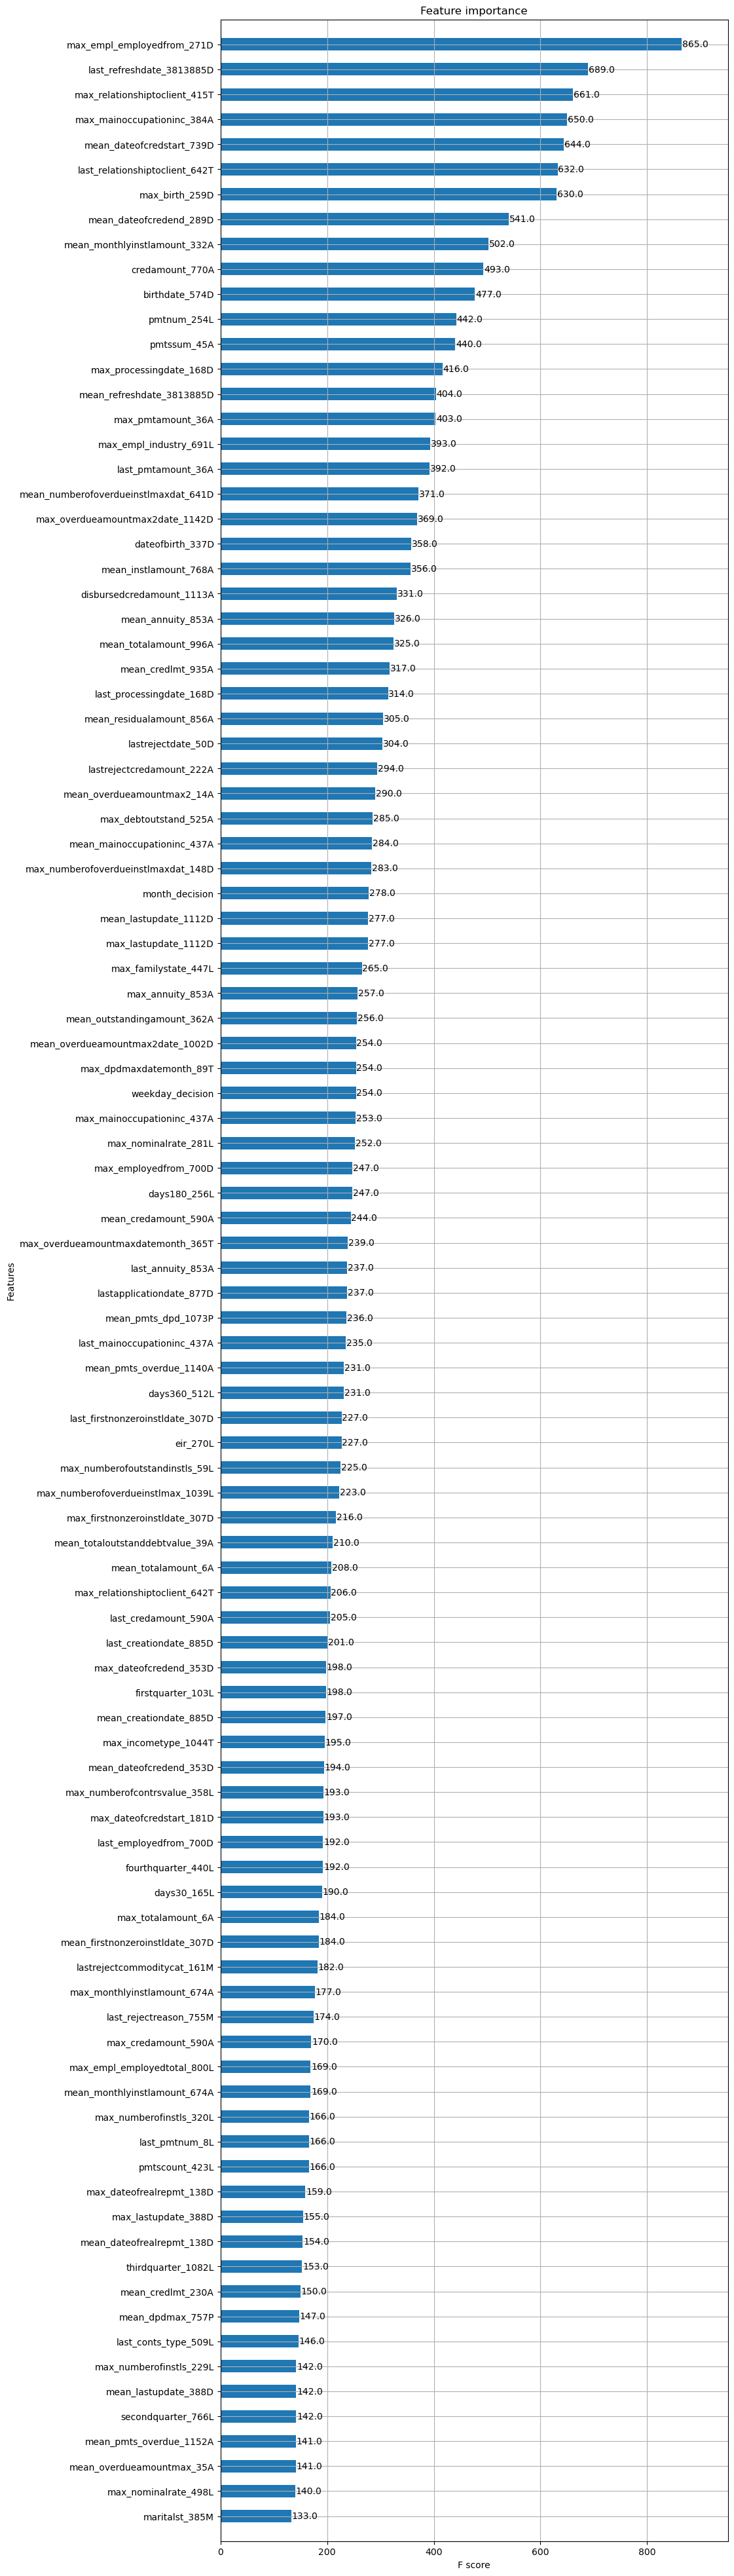

In [30]:
fig, ax = plt.subplots(figsize=(10, 50))

xgb.plot_importance(fitted_models[2], importance_type="weight", height=0.5, max_num_features=100, ax=ax)
plt.show()

In [37]:
## LightGBM

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 600,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "reg_alpha": 0.1,  
    "reg_lambda": 10,  
    "device": "gpu" if device == 'gpu' else "cpu",
    "random_state": 42,
}

fitted_models_lgb = []
cv_scores_lgb = []

for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
    
    LGB_model = lgb.train(params, dtrain, num_boost_round=params["n_estimators"],
                      valid_sets=[dtrain, dvalid])
    
    fitted_models_lgb.append(LGB_model)
    
    y_pred_valid = LGB_model.predict(X_valid, num_iteration=LGB_model.best_iteration)
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)

print("CV AUC scores: ", cv_scores_lgb)
print("Maximum CV AUC score: ", max(cv_scores_lgb))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1397, number of negative: 38016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29207
[LightGBM] [Info] Number of data points in the train set: 39413, number of used features: 371
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035445 -> initscore=-3.303680
[LightGBM] [Info] Start training from score -3.303680
[LightGBM] [Warning] Accuracy may be bad since you 

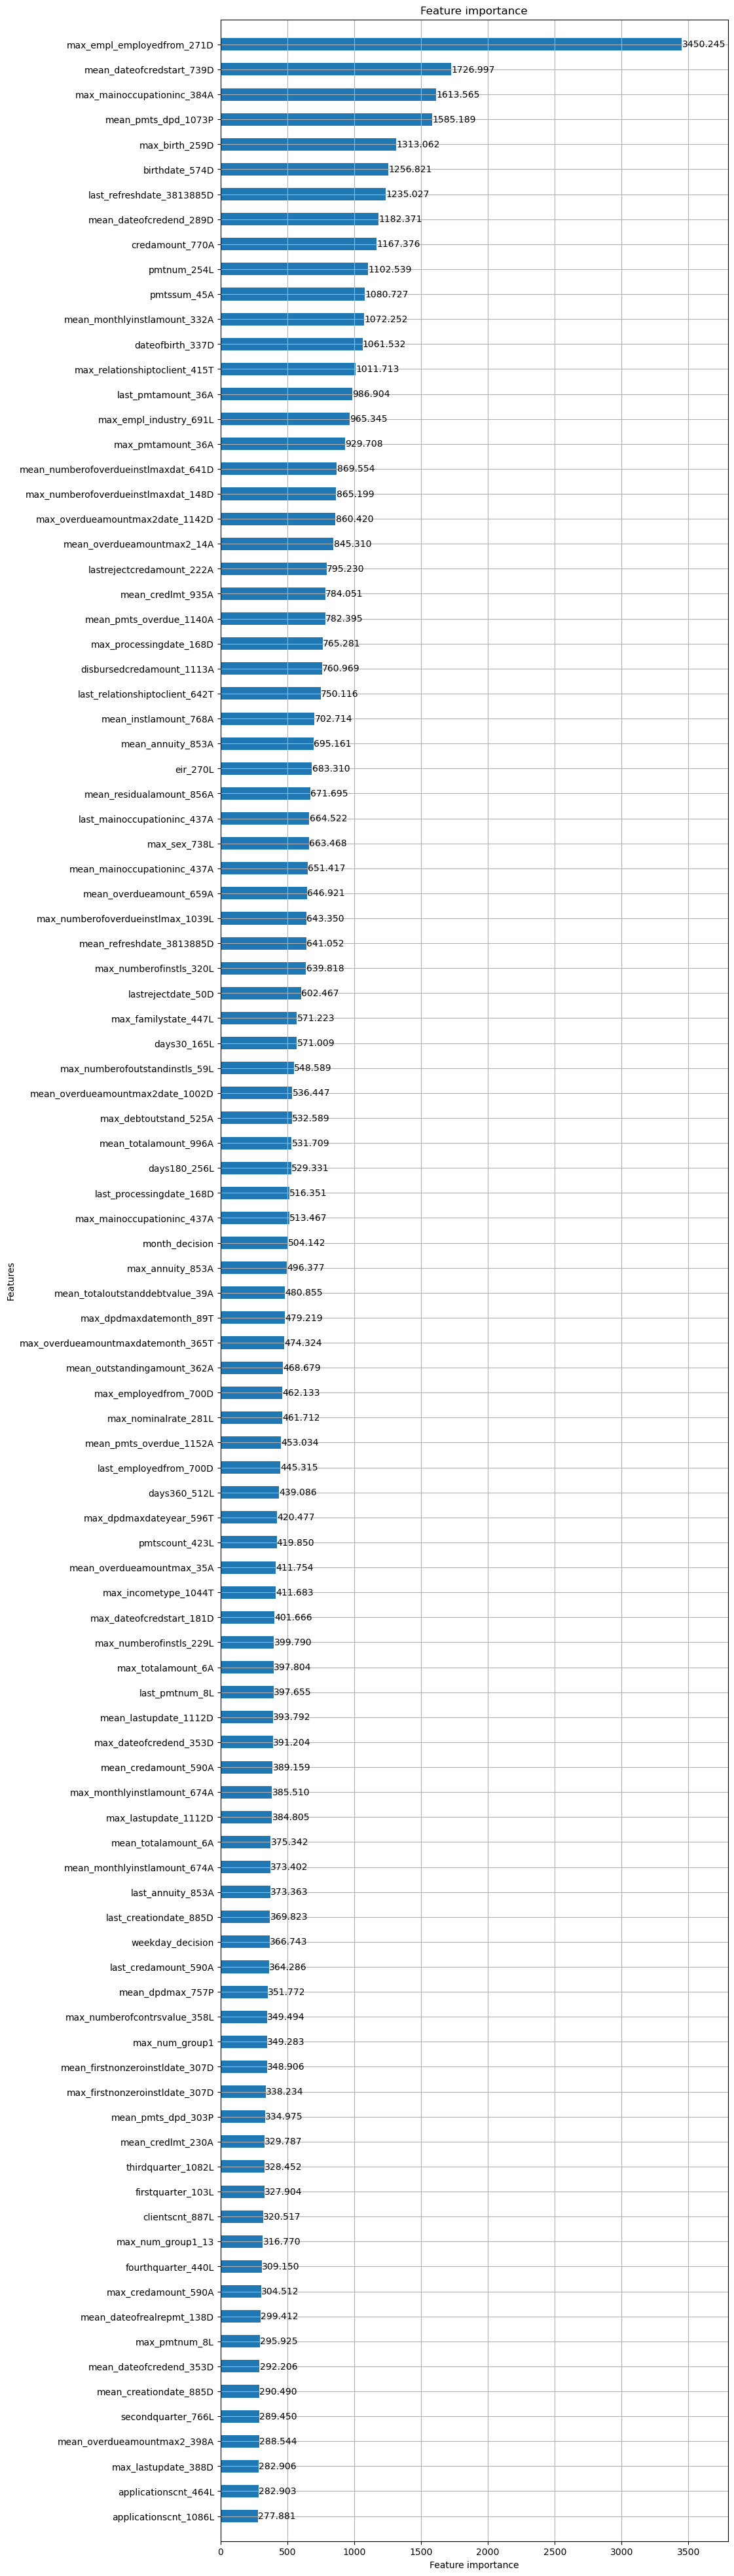

In [38]:
fig, ax = plt.subplots(figsize=(10, 50))

lgb.plot_importance(fitted_models_lgb[2], importance_type="gain", height=0.5, max_num_features=100, ax=ax)
plt.show()
